# Project E Simple Object Tracking - 02_Train_CNN

The purpose of this notebook is to train a Convolutional Neural Network (CNN) 
(from scratch) to classify five handheld objects from short video clips. 
The provided dataset contains a total of 488 clips, each consisting of 
15 RGB frames of size 100x100. Each frame is labeled with one of the 
five object classes:

1. Ball  
2. Mug  
3. Pen  
4. Spoon  
5. Notebook 

### 1. Imports and setup

In this cell I import all of the Python packages that I need for the project:

- **NumPy / pandas / matplotlib** for numerical operations, reading CSV files, and plotting.
- **scikit-learn** for splitting the data into training and validation sets.
- **TensorFlow / Keras** to build and train the convolutional neural network (CNN).
- I also optionally set random seeds for NumPy and TensorFlow so that the results are reproducible.

This cell doesn’t do any learning yet – it just sets up the environment.

In [1]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Reproducibility
np.random.seed(0)
tf.random.set_seed(0)


### 2. Load the video dataset from `.npy` files

Here I load the main dataset from the two `.npy` files that were provided:

- `training_data_projectE.npy` contains the **video clips**
- `training_labels_projectE.npy` contains the **one-hot class labels**

The shapes print out as:

- `(num_clips, 15, 100, 100, 3)` for the video data  
- `(num_clips, 15, 5)` for the labels  

So each clip has **15 frames**, each frame is a **100×100 RGB image**, and we have **5 object classes**.  

This cell is just verifying that the raw data loaded correctly and that the dimensions match the project description.

In [2]:
# Load full training dataset (clips)
data_training = np.load('../data/training_data_projectE.npy')
labels_training = np.load('../data/training_labels_projectE.npy', allow_pickle=True)

print("data_training.shape:", data_training.shape)   # (488, 15, 100, 100, 3)
print("labels_training.shape:", labels_training.shape)  # (488, 15, 5)

num_clips_all, num_frames, H, W, C = data_training.shape
print("num_clips_all:", num_clips_all)
print("num_frames per clip:", num_frames)
print("frame size:", H, W, "channels:", C)


data_training.shape: (488, 15, 100, 100, 3)
labels_training.shape: (488, 15, 5)
num_clips_all: 488
num_frames per clip: 15
frame size: 100 100 channels: 3


### 3. Load bounding-box annotations from CSV files

Bounding boxes are not stored in the `.npy` files.  
Instead, they are in separate CSV files – one CSV per video clip – in the `Final_Project_csv` folder.

In this cell I:

1. Read all CSV files from that folder.
2. Count how many CSV files there are.
3. Use only the **first N clips** from the `.npy` files, where N is the number of CSVs (about 100).  

This is because only that subset of clips actually has bounding-box annotations.  

The result of this cell is:

- `data_training_used`  → video clips **with** bounding boxes
- `labels_training_used` → corresponding class labels

These are the clips I will use for joint **classification + localization** training.

In [3]:
# FOLDER WHERE YOUR CSV FILES LIVE
csv_root = r"D:\Documents\Fundamentals of Machine Learning\Final_Project_csv"

# Get a sorted list of all CSV files (assumes one CSV per clip)
csv_files = sorted(glob.glob(os.path.join(csv_root, "*.csv")))
print("Number of CSV files (clips with bboxes):", len(csv_files))

# Use only these clips for joint class + bbox training
num_clips = len(csv_files)
print("Using num_clips =", num_clips)

# Subset the npy arrays to those clips
data_training_used   = data_training[:num_clips]        # (100, 15, 100,100,3)
labels_training_used = labels_training[:num_clips]      # (100, 15, 5)

print("data_training_used.shape:", data_training_used.shape)
print("labels_training_used.shape:", labels_training_used.shape)


Number of CSV files (clips with bboxes): 100
Using num_clips = 100
data_training_used.shape: (100, 15, 100, 100, 3)
labels_training_used.shape: (100, 15, 5)


### 4. Build per-frame bounding boxes from CSVs

The CSV files describe, for each frame, the bounding box of the object in pixel coordinates:

- `bbox_x, bbox_y`     – top-left corner  
- `bbox_width, bbox_height` – width and height  
- `image_width, image_height` – full frame size  

However, some CSVs have **more or fewer than 15 frames**, while the `.npy` clips always have exactly 15 frames.  
To align them, I:

- **Downsample** CSVs that have more than 15 rows (evenly spaced)  
- **Pad** CSVs that have fewer than 15 rows by repeating the last row  

After that, every clip has exactly 15 bounding boxes.

Then I convert each box to normalized coordinates in \([0,1]\):

`[x_min, y_min, x_max, y_max]`

and stack them into:

- `bboxes_training` with shape `(num_clips, 15, 4)`

These are the ground-truth boxes used for training the localization head and computing IoU.

In [4]:
bboxes_per_clip = []

for csv_path in csv_files:
    df = pd.read_csv(csv_path)

    # If CSV has more than the required number of frames, evenly sample them.
    if len(df) > num_frames:
        idx = np.linspace(0, len(df)-1, num_frames).astype(int)
        df = df.iloc[idx].reset_index(drop=True)

    # If CSV has fewer than required frames, repeat last frame
    elif len(df) < num_frames:
        repeat_count = num_frames - len(df)
        last_row = df.iloc[[-1]].copy()
        df = pd.concat([df] + [last_row]*repeat_count, ignore_index=True)

    # Now length is guaranteed to be num_frames
    assert len(df) == num_frames

    # Pixel coords
    x  = df["bbox_x"].values.astype("float32")
    y  = df["bbox_y"].values.astype("float32")
    bw = df["bbox_width"].values.astype("float32")
    bh = df["bbox_height"].values.astype("float32")

    w = df["image_width"].values.astype("float32")
    h = df["image_height"].values.astype("float32")

    # Convert to normalized [0,1] corners: [x_min, y_min, x_max, y_max]
    x_min = x / w
    y_min = y / h
    x_max = (x + bw) / w
    y_max = (y + bh) / h

    boxes = np.stack([x_min, y_min, x_max, y_max], axis=1)  # (15, 4)
    bboxes_per_clip.append(boxes)

# (num_clips, num_frames, 4)
bboxes_training = np.stack(bboxes_per_clip, axis=0)
print("bboxes_training.shape:", bboxes_training.shape)

# ---- Flatten clips → frames ----
frames = data_training_used.reshape(num_clips * num_frames, H, W, C)               # (N, 100,100,3)
frame_labels_onehot = labels_training_used.reshape(num_clips * num_frames, 5)     # (N, 5)
frame_labels = np.argmax(frame_labels_onehot, axis=1)                              # (N,)
frame_bboxes = bboxes_training.reshape(num_clips * num_frames, 4).astype("float32")# (N, 4)

print("frames.shape:", frames.shape)
print("frame_labels.shape:", frame_labels.shape)
print("frame_bboxes.shape:", frame_bboxes.shape)


bboxes_training.shape: (100, 15, 4)
frames.shape: (1500, 100, 100, 3)
frame_labels.shape: (1500,)
frame_bboxes.shape: (1500, 4)


### 5. Flatten clips into per-frame samples

The model will operate **per frame**, not per clip.  
So in this cell I reshape everything from clip level to frame level:

- `frames` → shape `(N, 100, 100, 3)` where \(N = \text{num_clips} × 15\)
- `frame_labels_onehot` → shape `(N, 5)`
- `frame_labels` → integer class indices from 0 to 4
- `frame_bboxes` → shape `(N, 4)` for the normalized bounding boxes

After this flattening, each entry in the dataset corresponds to:

> one image frame + one class label + one bounding box.

This is exactly what the CNN expects as input and targets.


In [5]:
X_train, X_val, y_class_train, y_class_val, y_box_train, y_box_val = train_test_split(
    frames,
    frame_labels,
    frame_bboxes,
    test_size=0.2,
    random_state=0,
    stratify=frame_labels
)

print("X_train.shape:", X_train.shape)
print("X_val.shape:", X_val.shape)
print("y_class_train.shape:", y_class_train.shape)
print("y_box_train.shape:", y_box_train.shape)



X_train.shape: (1200, 100, 100, 3)
X_val.shape: (300, 100, 100, 3)
y_class_train.shape: (1200,)
y_box_train.shape: (1200, 4)


### 6. Train / validation split

Here I split the frame-level data into:

- **training set** (80%)
- **validation set** (20%)

using `train_test_split` from scikit-learn.

I stratify by the class labels so that each object class is represented fairly in both splits.  

The outputs are:

- `X_train`, `X_val` – images
- `y_class_train`, `y_class_val` – class labels
- `y_box_train`, `y_box_val` – bounding boxes

The validation set is used only for monitoring performance and detecting overfitting; the model is not trained on it.


In [6]:
# Normalize to [0, 1]
X_train_tf = X_train.astype('float32') / 255.0
X_val_tf   = X_val.astype('float32') / 255.0

### 7. Normalize image data

In this cell I convert the image data to `float32` and scale pixel values from `[0, 255]` down to `[0, 1]`.

This normalization step is standard for CNNs and helps the optimizer converge more smoothly.

I also store:

- `num_classes = 5`
- `input_shape = (100, 100, 3)`  

which are used when building the Keras model.


In [7]:
num_classes = 5
input_shape = (H, W, C)  # (100, 100, 3)

print("input_shape:", input_shape)


input_shape: (100, 100, 3)


### 8. Define the CNN architecture

Here I build the actual neural network using the Keras Functional API.

The structure is:

1. **Shared feature extractor**  
   - Conv2D → ReLU → MaxPooling  
   - Conv2D → ReLU → MaxPooling  
   - Flatten → Dense(128, ReLU) → Dropout(0.3)  

2. **Classification head**  
   - Dense(5, softmax) → predicts the object class (ball, mug, pen, spoon, notebook)  

3. **Bounding-box head**  
   - Dense(4, sigmoid) → predicts \([x_{\min}, y_{\min}, x_{\max}, y_{\max}]\) in \([0,1]\)

This is a small, interpretable 2-block CNN.  
The same features are shared between the class prediction and the bounding-box regression.

In [8]:
inputs = keras.Input(shape=input_shape, name="image")

# Block 1: Conv-ReLU-Pool
x = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)   # 100 -> 50

# Block 2: Conv-ReLU-Pool
x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)   # 50 -> 25

# Shared dense
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)

# Classification head (5-way softmax)
class_output = layers.Dense(num_classes, activation='softmax', name='class')(x)

# Bounding box head (4 outputs in [0, 1])
bbox_output = layers.Dense(4, activation='sigmoid', name='bbox')(x)

model = keras.Model(inputs=inputs, outputs=[class_output, bbox_output],
                    name="simple_cnn_class_and_bbox")

model.summary()


Model: "simple_cnn_class_and_bbox"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)               ┃ Output Shape           ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)         │ (None, 100, 100, 3)    │              0 │ -                       │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ conv2d (Conv2D)            │ (None, 100, 100, 16)   │            448 │ image[0][0]             │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ max_pooling2d              │ (None, 50, 50, 16)     │              0 │ conv2d[0][0]            │
│ (MaxPooling2D)             │                        │                │                         │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ conv2d_1 (Conv2D)          │ (None, 50, 50, 32)     │          4,640 │ max_pooling2d[0][0]     │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ max_pooling2d_1            │ (None, 25, 25, 32)     │              0 │ conv2d_1[0][0]          │
│ (MaxPooling2D)             │                        │                │                         │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ flatten (Flatten)          │ (None, 20000)          │              0 │ max_pooling2d_1[0][0]   │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ dense (Dense)              │ (None, 128)            │      2,560,128 │ flatten[0][0]           │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ class (Dense)              │ (None, 5)              │            645 │ dense[0][0]             │
├────────────────────────────┼────────────────────────┼────────────────┼─────────────────────────┤
│ bbox (Dense)               │ (None, 4)              │            516 │ dense[0][0]             │
└────────────────────────────┴────────────────────────┴────────────────┴─────────────────────────┘

 Total params: 2,566,377 (9.79 MB)

 Trainable params: 2,566,377 (9.79 MB)

 Non-trainable params: 0 (0.00 B)

### 9. Compile the model with multi-task losses

In this cell I tell Keras **how to train** the model by specifying:

- **Optimizer:** Adam with a small learning rate.  
- **Loss for the classification head:** `sparse_categorical_crossentropy`.  
- **Loss for the bounding-box head:** Huber (smooth L1), which is more robust than pure MSE.  
- **Metrics:**  
  - accuracy for the class head  
  - MSE for the bbox head  

I also set **loss weights**:

- 1.0 for the classification loss  
- 5.0 for the bbox loss  

This means the total loss is a weighted sum, and the model is encouraged to pay more attention to getting bounding boxes reasonably accurate while still classifying correctly.

In [9]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss={
        "class": "sparse_categorical_crossentropy",
        "bbox": "mse",
    },
    metrics={
        "class": ["accuracy"],
        "bbox": ["mse"],
    },
    loss_weights={
        "class": 1.0,
        "bbox": 5.0,   # emphasize bbox a bit more
    },
)

### 10. Train the CNN (`train()` function)

This cell defines and runs the training loop using Keras’ `model.fit`.

Key points:

- Inputs: `X_train_tf` (images)  
- Targets: a dictionary with  
  - `"class"` → `y_class_train`  
  - `"bbox"` → `y_box_train`  

- Validation data: `(X_val_tf, {"class": y_class_val, "bbox": y_box_val})`
- Number of epochs: around 30
- Batch size: 64  

During training, Keras automatically tracks:

- `loss`, `val_loss`
- `class_accuracy`, `val_class_accuracy`
- `bbox_loss`, `val_bbox_loss`, etc.

At the end, the trained model is saved to `../models/simple_cnn_class_and_bbox.h5` and the training `history` object is returned for plotting.


In [10]:
def train(num_epochs=30, batch_size=64):
    history = model.fit(
        x=X_train_tf,
        y={"class": y_class_train, "bbox": y_box_train},
        validation_data=(X_val_tf, {"class": y_class_val, "bbox": y_box_val}),
        epochs=num_epochs,
        batch_size=batch_size,
        verbose=1
    )

    os.makedirs('../models', exist_ok=True)
    model.save('../models/simple_cnn_class_and_bbox.h5')
    print("Model saved to ../models/simple_cnn_class_and_bbox.h5")

    return history

history = train(num_epochs=30, batch_size=64)


Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - bbox_loss: 0.0336 - bbox_mse: 0.0336 - class_accuracy: 0.4100 - class_loss: 1.3280 - loss: 1.4994 - val_bbox_loss: 0.0283 - val_bbox_mse: 0.0284 - val_class_accuracy: 0.5967 - val_class_loss: 1.1317 - val_loss: 1.2838
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - bbox_loss: 0.0241 - bbox_mse: 0.0240 - class_accuracy: 0.6450 - class_loss: 0.9403 - loss: 1.0625 - val_bbox_loss: 0.0250 - val_bbox_mse: 0.0250 - val_class_accuracy: 0.6433 - val_class_loss: 0.9577 - val_loss: 1.0924
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - bbox_loss: 0.0213 - bbox_mse: 0.0213 - class_accuracy: 0.7317 - class_loss: 0.7305 - loss: 0.8385 - val_bbox_loss: 0.0246 - val_bbox_mse: 0.0245 - val_class_accuracy: 0.7033 - val_class_loss: 0.7999 - val_loss: 0.9311
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - bbox_loss: 0.0185 - bbox_mse: 0.0184 - class_accuracy: 0.8092 - class_loss: 0.5584 - loss: 0.6527 - val_bbox_loss: 0.0226 - val_bbox_m

Model saved to ../models/simple_cnn_class_and_bbox.h5


### 11. Plot training vs. validation loss and accuracy

Here I visualize the contents of the `history` object:

- On the left, I plot **training loss vs validation loss** across epochs.  
  This shows how well the model is fitting and whether it is overfitting.  

- On the right, I plot **classification accuracy** for train and validation sets.  
  This shows how well the model is recognizing the object categories.

These plots are useful both for debugging and for explaining how the model behaves during training in the report/presentation.

dict_keys(['bbox_loss', 'bbox_mse', 'class_accuracy', 'class_loss', 'loss', 'val_bbox_loss', 'val_bbox_mse', 'val_class_accuracy', 'val_class_loss', 'val_loss'])


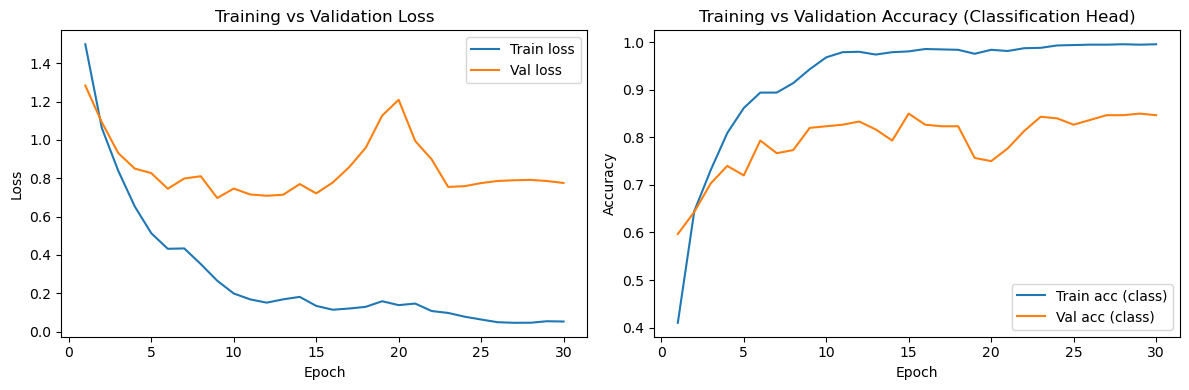

In [11]:
history_dict = history.history
print(history_dict.keys())  # quick check of available metrics

epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(12, 4))

# --- Total Loss ---
plt.subplot(1, 2, 1)
plt.plot(epochs, history_dict['loss'], label='Train loss')
plt.plot(epochs, history_dict['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# --- Classification Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(epochs, history_dict['class_accuracy'], label='Train acc (class)')
plt.plot(epochs, history_dict['val_class_accuracy'], label='Val acc (class)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (Classification Head)')
plt.legend()

plt.tight_layout()
plt.show()


### 12. IoU helper function

Intersection-over-Union (IoU) is the main metric for localization quality in this project.

In this cell I define a helper function `iou_boxes(true_boxes, pred_boxes)` that:

- Takes arrays of true and predicted bounding boxes in the format `[x_min, y_min, x_max, y_max]`.
- Computes the area of overlap and the area of union for each pair.
- Returns the IoU for each sample.

This function is used later to compute the **average IoU over correctly classified frames**, which is exactly how the project is graded.

In [15]:
def iou_boxes(boxes_true, boxes_pred):
    x1_true, y1_true, x2_true, y2_true = np.split(boxes_true, 4, axis=1)
    x1_pred, y1_pred, x2_pred, y2_pred = np.split(boxes_pred, 4, axis=1)

    x1_int = np.maximum(x1_true, x1_pred)
    y1_int = np.maximum(y1_true, y1_pred)
    x2_int = np.minimum(x2_true, x2_pred)
    y2_int = np.minimum(y2_true, y2_pred)

    inter_w = np.clip(x2_int - x1_int, 0, None)
    inter_h = np.clip(y2_int - y1_int, 0, None)
    inter_area = inter_w * inter_h

    area_true = (x2_true - x1_true) * (y2_true - y1_true)
    area_pred = (x2_pred - x1_pred) * (y2_pred - y1_pred)
    union_area = area_true + area_pred - inter_area

    iou = inter_area / np.clip(union_area, 1e-7, None)
    return iou.squeeze()


### 13. Test function: classification accuracy and IoU

This cell defines a `test()` function that evaluates the trained model on a given dataset (here I use the validation set):

1. Run `model.predict` to get:
   - class probabilities
   - predicted bounding boxes.

2. Convert probabilities to predicted class labels using `argmax`.

3. Compute a mask of **correctly classified frames**.

4. Compute:
   - **Classification accuracy** (correct / total)
   - **Average IoU**, but only over the correctly classified frames, using the `iou_boxes` helper.

This matches the grading metric:  
> “Average IoU on correctly classified samples.”

Finally, I call `test(X_val_tf, y_class_val, y_box_val)` and print the final validation accuracy and IoU numbers.


In [16]:
def test(X_eval, y_class_eval, y_box_eval):
    pred_class_probs, pred_bboxes = model.predict(X_eval)
    pred_class_labels = np.argmax(pred_class_probs, axis=1)

    correct_mask = (pred_class_labels == y_class_eval)
    num_correct = correct_mask.sum()
    total = len(y_class_eval)
    acc = num_correct / total
    print(f"Classification accuracy (frame-level): {acc:.3f} ({num_correct}/{total})")

    if num_correct > 0:
        correct_bboxes_true = y_box_eval[correct_mask]
        correct_bboxes_pred = pred_bboxes[correct_mask]

        ious = iou_boxes(correct_bboxes_true, correct_bboxes_pred)
        mean_iou = ious.mean()
        print(f"Average IoU over correctly classified samples: {mean_iou:.3f}")
    else:
        mean_iou = 0.0
        print("No correctly classified samples to compute IoU.")

    return acc, mean_iou

val_acc, val_mean_iou = test(X_val_tf, y_class_val, y_box_val)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Classification accuracy (frame-level): 0.847 (254/300)
Average IoU over correctly classified samples: 0.425


### 14. Visualize a random validation frame with predicted and true bounding boxes

This cell randomly selects one frame from the validation set and:

- Displays the image.
- Draws the **ground-truth bounding box** in green.
- Draws the **predicted bounding box** in red.
- Shows the true and predicted class labels in the title.

This is a qualitative check that complements the numerical metrics (accuracy and IoU) and lets us visually inspect how well the model is localizing and classifying the object.

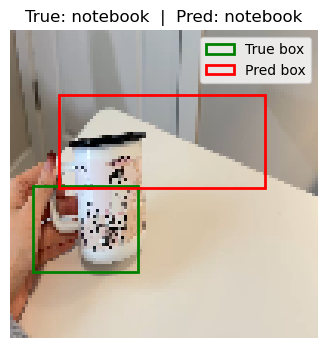

In [52]:
import random
import matplotlib.patches as patches

# Class index → name (note: our labels are 0–4)
label_names = {
    0: 'ball',
    1: 'mug',
    2: 'pen',
    3: 'spoon',
    4: 'notebook'
}

def show_random_val_frame():
    # pick a random index from the validation set
    idx = np.random.randint(len(X_val_tf))

    img = X_val_tf[idx]              # (100, 100, 3), values in [0,1]
    true_class = int(y_class_val[idx])
    true_box   = y_box_val[idx]      # [x_min, y_min, x_max, y_max] in [0,1]

    # run model on this single frame
    pred_probs, pred_boxes = model.predict(img[None, ...], verbose=0)
    pred_class = int(np.argmax(pred_probs[0]))
    pred_box   = pred_boxes[0]

    H, W = img.shape[0], img.shape[1]

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(img)
    ax.axis('off')

    # --- draw TRUE bbox (green) ---
    x1_t, y1_t, x2_t, y2_t = true_box
    rect_t = patches.Rectangle(
        (x1_t * W, y1_t * H),
        (x2_t - x1_t) * W,
        (y2_t - y1_t) * H,
        linewidth=2, edgecolor='g', facecolor='none', label='True box'
    )
    ax.add_patch(rect_t)

    # --- draw PREDICTED bbox (red) ---
    x1_p, y1_p, x2_p, y2_p = pred_box
    rect_p = patches.Rectangle(
        (x1_p * W, y1_p * H),
        (x2_p - x1_p) * W,
        (y2_p - y1_p) * H,
        linewidth=2, edgecolor='r', facecolor='none', label='Pred box'
    )
    ax.add_patch(rect_p)

    # title with true/pred labels
    title = f"True: {label_names[true_class]}  |  Pred: {label_names[pred_class]}"
    ax.set_title(title)
    ax.legend(loc='upper right')
    plt.show()

# call it
show_random_val_frame()
